In [1]:
import importlib.util
spec = importlib.util.spec_from_file_location("BoundaryLayerToolbox", "/Users/claudiopierard/VC/BoundaryLayerToolbox.py")
blt = importlib.util.module_from_spec(spec)
spec.loader.exec_module(blt)

In [2]:
import matplotlib
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as spy
import scipy.io as sio
import scipy.optimize as optimization
import scipy.interpolate as interpolate
from netCDF4 import Dataset
import os
import pandas as pd
pd.set_option('html', False)
from IPython import display
from matplotlib import animation
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [3]:
xlat = np.loadtxt("/Users/claudiopierard/VC/datos/xlat_d02_interpolado.txt")
xlong = np.loadtxt("/Users/claudiopierard/VC/datos/xlong_d02_interpolado.txt")
hgt = np.loadtxt("/Users/claudiopierard/VC/datos/hgt_d02_interpolado.txt")

In [4]:
months = {1:'jan', 2:'feb', 3:'mar',4: 'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dic'}

In [5]:
path2datosVC = "/Volumes/BUFFALO_SOLDIER/datos_VC/"
path2estaciones = "../datos/loc_estaciones/air_quality_stn.xy"

In [6]:
estaciones = pd.read_table(path2estaciones, index_col=0, names=['long','lat', 'height'])

In [7]:
estaciones = estaciones.transpose().to_dict()

#  APRIL

In [8]:
apr_24 = h5py.File("/Volumes/BUFFALO_SOLDIER/datos_VC/04/apr_24.h5", 'r')
apr_48 = h5py.File("/Volumes/BUFFALO_SOLDIER/datos_VC/04/apr_48.h5", 'r')

In [9]:
apr_t_range = pd.date_range("2015-04-02 00:00:00", "2015-04-30 23:00:00", freq='1H')

In [10]:
vc_24 = np.array(apr_24.get('vc_24h'))
pblh_24 = np.array(apr_24.get('pblh_24h'))
u_mean_24 = np.array(apr_24.get('u_mean_24h'))

In [11]:
vc_48 = np.array(apr_48.get('vc_48h'))
pblh_48 = np.array(apr_48.get('pblh_48h'))
u_mean_48 = np.array(apr_48.get('u_mean_48h'))

In [12]:
o3_2015 = pd.read_csv("../datos/contaminantes/2015/CUA_o3_2015_noCol.csv", names=['date','hour','station','cont', 'unit', 'O3'])

In [13]:
o3_2015.index = pd.date_range('2015-01-01 01:00:00', '2016-01-01 00:00:00', freq='1H')

In [14]:
del o3_2015['station'], o3_2015['unit'], o3_2015['cont'], o3_2015['hour'], o3_2015['date']

In [15]:
co_2015 = pd.read_csv("../datos/contaminantes/2015/CUA_co_2015_noCol.csv", names=['date','hour','station','cont', 'unit', 'co'])
co_2015.index = pd.date_range('2015-01-01 01:00:00', '2016-01-01 00:00:00', freq='1H')
del co_2015['station'], co_2015['unit'], co_2015['cont'], co_2015['hour'], co_2015['date']

## CUA

In [16]:
cua_ix = blt.near_coord_loc(xlong, xlat, estaciones['CUA']['long'], estaciones['CUA']['lat'])

In [17]:
cua_ix

(58, 35)

In [18]:
A = blt.wrf2dataframe(vc_24, vc_48, apr_t_range, cua_ix[0], cua_ix[1], 'cua_vc')
B = blt.wrf2dataframe(pblh_24, pblh_48, apr_t_range, cua_ix[0], cua_ix[1], 'cua_pblh')
C = blt.wrf2dataframe(u_mean_24, u_mean_48, apr_t_range, cua_ix[0], cua_ix[1], 'cua_u_mean')

In [19]:
cua_DF_apr = pd.concat([A,B,C], axis=1)

In [20]:
cua_DF_apr = cua_DF_apr.reindex(pd.date_range('2015-04-01 00:00:00','2015-04-30 23:00:00', freq='1H'))

In [21]:
cua_DF_apr = pd.concat([cua_DF_apr, o3_2015['2015-04-01':'2015-04-30']], axis=1)

In [22]:
cua_DF_apr = pd.concat([cua_DF_apr, co_2015['2015-04-01':'2015-04-30']], axis=1)

In [23]:
cua_DF_apr.head(2)

                     cua_vc_24  cua_vc_48  cua_pblh_24  cua_pblh_48  \
2015-04-01 00:00:00        NaN        NaN          NaN          NaN   
2015-04-01 01:00:00        NaN        NaN          NaN          NaN   

                     cua_u_mean_24  cua_u_mean_48    O3   co  
2015-04-01 00:00:00            NaN            NaN  13.0  0.8  
2015-04-01 01:00:00            NaN            NaN  13.0  0.7  

#### VC vs $O_3$

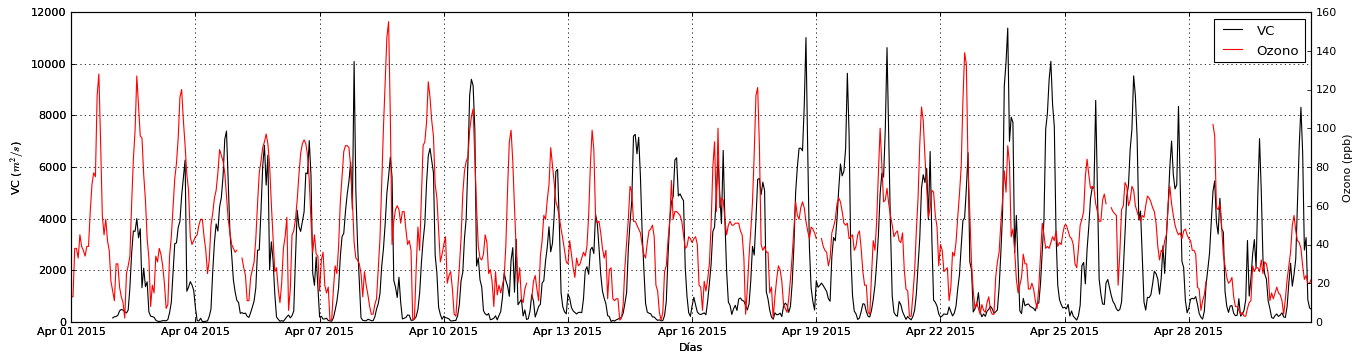

In [24]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_apr['cua_vc_24'],  c = 'k', label = 'VC')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_apr['O3'], c = 'r', label = 'Ozono')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


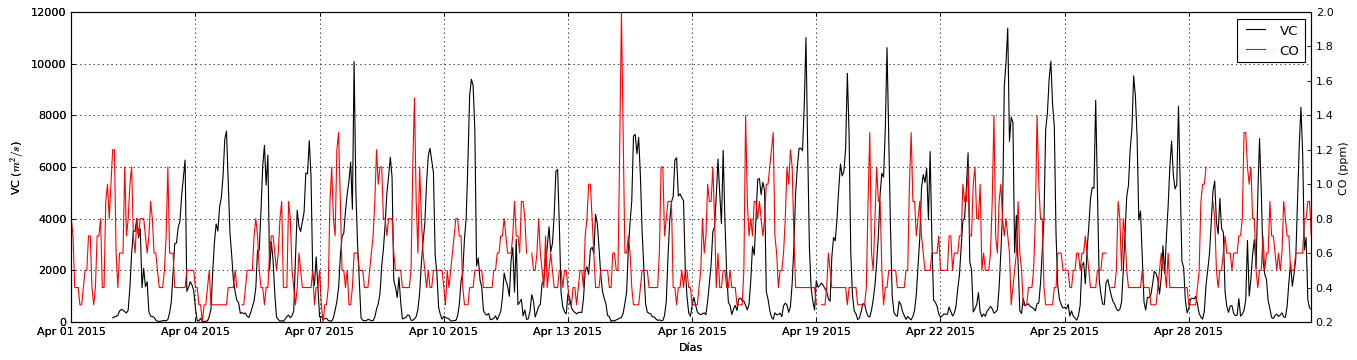

In [25]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("CO (ppm)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_apr['cua_vc_24'],  c = 'k', label = 'VC')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_apr['co'], c = 'r', label = 'CO')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


#### PBLH vs $O_3$

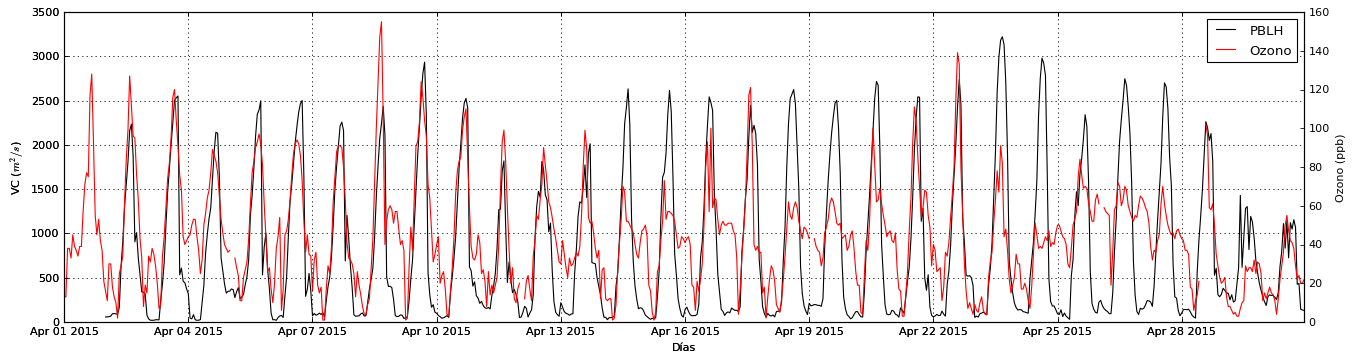

In [26]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_apr['cua_pblh_24'],  c = 'k', label = 'PBLH')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_apr['O3'], c = 'r', label = 'Ozono')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


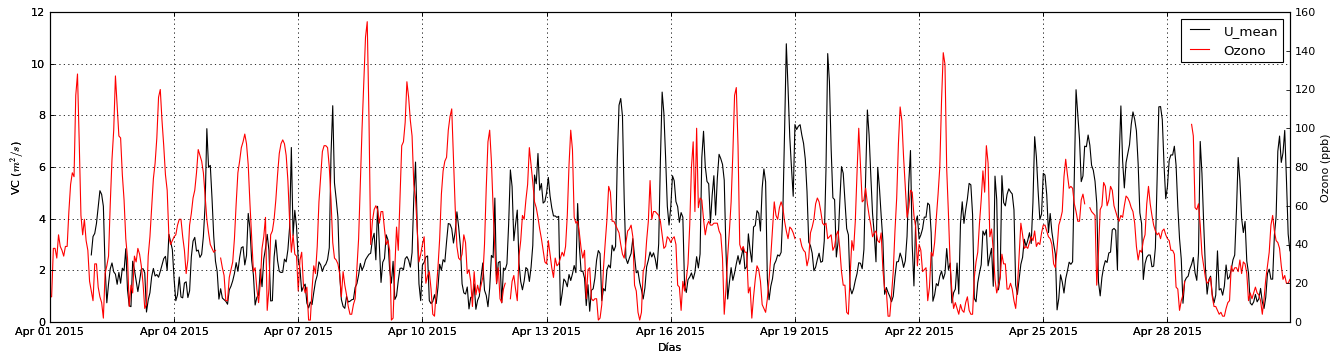

In [27]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_apr['cua_u_mean_24'],  c = 'k', label = 'U_mean')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_apr['O3'], c = 'r', label = 'Ozono')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


## Marzo

In [28]:
mar_24 = h5py.File("/Volumes/BUFFALO_SOLDIER/datos_VC/03/mar_24.h5", 'r')
mar_48 = h5py.File("/Volumes/BUFFALO_SOLDIER/datos_VC/03/mar_48.h5", 'r')

In [29]:
mar_t_range = pd.date_range("2015-03-01 00:00:00", "2015-03-31 23:00:00", freq='1H')

In [30]:
vc_24 = np.array(mar_24.get('vc_24h'))
pblh_24 = np.array(mar_24.get('pblh_24h'))
u_mean_24 = np.array(mar_24.get('u_mean_24h'))
vc_48 = np.array(mar_48.get('vc_48h'))
pblh_48 = np.array(mar_48.get('pblh_48h'))
u_mean_48 = np.array(mar_48.get('u_mean_48h'))

In [31]:
A = blt.wrf2dataframe(vc_24, vc_48, mar_t_range, cua_ix[0], cua_ix[1], 'cua_vc')
B = blt.wrf2dataframe(pblh_24, pblh_48, mar_t_range, cua_ix[0], cua_ix[1], 'cua_pblh')
C = blt.wrf2dataframe(u_mean_24, u_mean_48, mar_t_range, cua_ix[0], cua_ix[1], 'cua_u_mean')

In [32]:
cua_DF_mar = pd.concat([A,B,C], axis=1)

In [33]:
cua_DF_mar = pd.concat([cua_DF_mar, o3_2015['2015-03-01':'2015-03-31']], axis=1)

In [34]:
cua_DF_mar = pd.concat([cua_DF_mar, co_2015['2015-03-01':'2015-03-31']], axis=1)

In [35]:
cua_DF_mar.head()

                     cua_vc_24  cua_vc_48  cua_pblh_24  cua_pblh_48  \
2015-03-01 00:00:00        255        339   111.120071   259.933716   
2015-03-01 01:00:00         41        325    29.838425   206.001205   
2015-03-01 02:00:00        208         84    99.572784   101.611084   
2015-03-01 03:00:00        138        123    95.188187   133.371964   
2015-03-01 04:00:00         42         93    28.026209   117.536308   

                     cua_u_mean_24  cua_u_mean_48    O3   co  
2015-03-01 00:00:00       2.032875       1.142063  11.0  0.8  
2015-03-01 01:00:00       1.600117       1.372429   NaN  NaN  
2015-03-01 02:00:00       2.088696       0.697553   NaN  NaN  
2015-03-01 03:00:00       1.401229       0.921774  16.0  0.4  
2015-03-01 04:00:00       1.809590       0.746634  10.0  0.5  

#### VC vs $O_3$

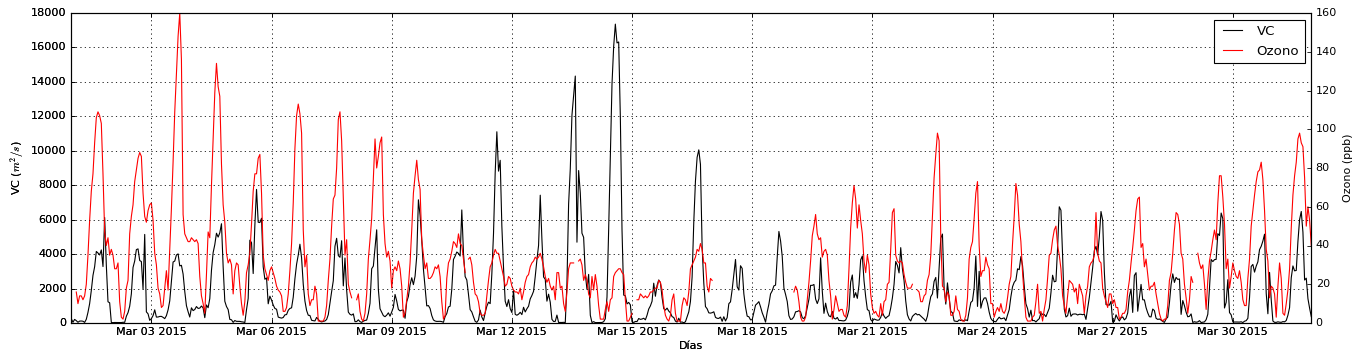

In [36]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_mar['cua_vc_24'],  c = 'k', label='VC')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_mar['O3'], c = 'r', label = 'Ozono')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


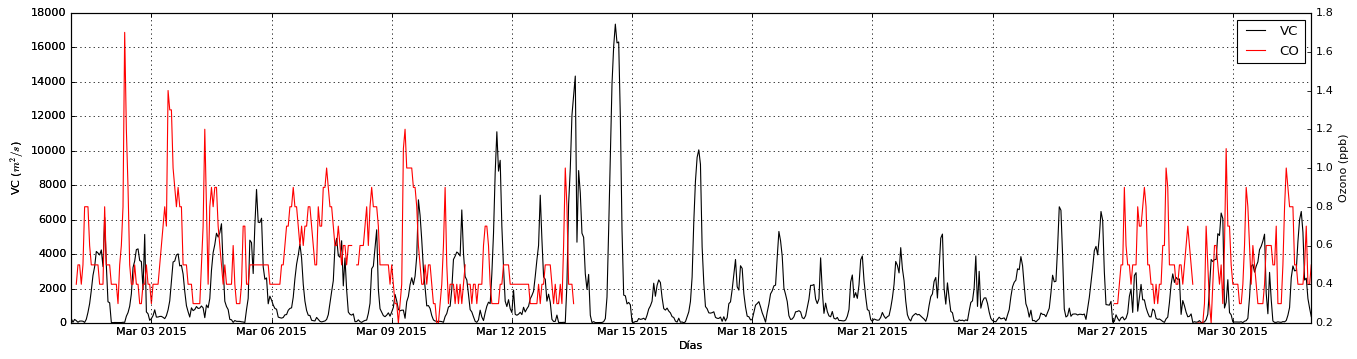

In [37]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_mar['cua_vc_24'],  c = 'k', label='VC')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_mar['co'], c = 'r', label = 'CO')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


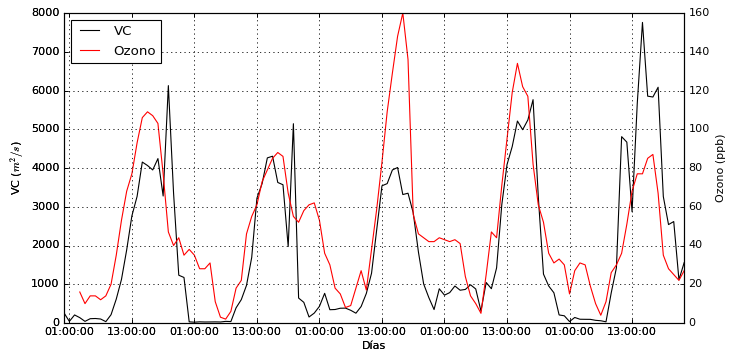

In [38]:
plt.figure(figsize=[10,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cua_DF_mar['2015-03-01':'2015-03-05']['cua_vc_24'],  c = 'k', label='VC')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cua_DF_mar['2015-03-01':'2015-03-05']['O3'], c = 'r', label = 'Ozono')
#par1.set_ylim(0, 4)

host.legend(loc = 'upper left')
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


# CCA

#### VC vs. PM_25

In [39]:
apr_24 = h5py.File("/Volumes/BUFFALO_SOLDIER/datos_VC/04/apr_24.h5", 'r')
apr_48 = h5py.File("/Volumes/BUFFALO_SOLDIER/datos_VC/04/apr_48.h5", 'r')
vc_24 = np.array(apr_24.get('vc_24h'))
pblh_24 = np.array(apr_24.get('pblh_24h'))
u_mean_24 = np.array(apr_24.get('u_mean_24h'))
vc_48 = np.array(apr_48.get('vc_48h'))
pblh_48 = np.array(apr_48.get('pblh_48h'))
u_mean_48 = np.array(apr_48.get('u_mean_48h'))

In [40]:
cca_ix = blt.near_coord_loc(xlong, xlat, estaciones['CCA']['long'], estaciones['CCA']['lat'])

apr_t_range = pd.date_range("2015-04-02 00:00:00", "2015-04-30 23:00:00", freq='1H')

A = blt.wrf2dataframe(vc_24, vc_48, apr_t_range, cca_ix[0], cca_ix[1], 'cca_vc')
B = blt.wrf2dataframe(pblh_24, pblh_48, apr_t_range, cca_ix[0], cca_ix[1], 'cca_pblh')
C = blt.wrf2dataframe(u_mean_24, u_mean_48, apr_t_range, cca_ix[0], cca_ix[1], 'cca_u_mean')
cca_DF_apr = pd.concat([A,B,C], axis=1)
cca_DF_apr = cca_DF_apr.reindex(pd.date_range('2015-04-01 00:00:00','2015-04-30 23:00:00', freq='1H'))


In [41]:
pm25_2015 = pd.read_csv("../datos/contaminantes/cca/PM25_CCA_fixed.csv", index_col=0)

In [42]:
pm25_2015.index = pd.date_range('2015-01-01 01:00:00', '2016-01-01 00:00:00', freq='1H')

In [43]:
cca_DF_apr = pd.concat([cca_DF_apr, pm25_2015['2015-04-01':'2015-04-30']], axis=1)

In [44]:
cca_DF_apr = cca_DF_apr.rename(columns={'value': 'pm25'})

In [45]:
cca_DF_apr.head(3)

                     cca_vc_24  cca_vc_48  cca_pblh_24  cca_pblh_48  \
2015-04-01 00:00:00        NaN        NaN          NaN          NaN   
2015-04-01 01:00:00        NaN        NaN          NaN          NaN   
2015-04-01 02:00:00        NaN        NaN          NaN          NaN   

                     cca_u_mean_24  cca_u_mean_48  pm25  
2015-04-01 00:00:00            NaN            NaN  14.0  
2015-04-01 01:00:00            NaN            NaN  16.0  
2015-04-01 02:00:00            NaN            NaN  17.0  

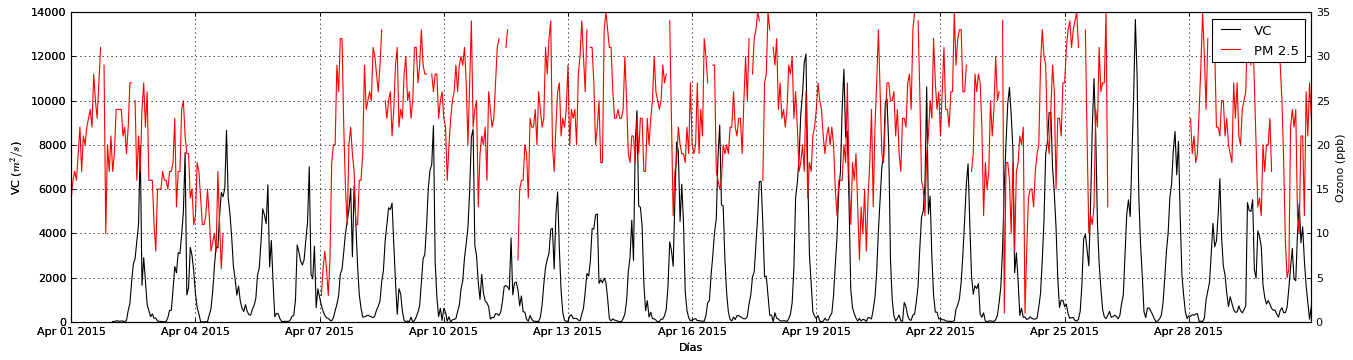

In [46]:
plt.figure(figsize=[20,5])
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()
par1 = host.twinx()

#offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

#host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Días")
host.set_ylabel("VC ($m^2/s$)")
par1.set_ylabel("Ozono (ppb)")

#host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(cca_DF_apr['cca_vc_24'],  c = 'k', label = 'VC')

#par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(cca_DF_apr['pm25'], c = 'r', label = 'PM 2.5')
#par1.set_ylim(0, 4)

host.legend()
host.grid()
#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
#host.set_xticks(range(1,13));
#host.set_xticklabels();


In [56]:
cca_DF_apr['cca_vc_24'].values.shape

(720,)

In [54]:
A = np.concatenate([cca_DF_apr['cca_vc_24'].values, cca_DF_apr['cca_vc_48'].values])

IndexError: axis 1 out of bounds [0, 1)

In [55]:
A.shape

(1440,)

In [73]:
cca_DF_apr['2015-04-03':'2015-04-05'].index.shape

(72,)

In [74]:
np.ones(72)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

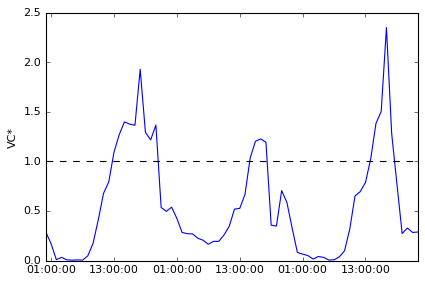

In [80]:
plt.plot( cca_DF_apr['cca_vc_48']['2015-04-03':'2015-04-05']/4000)
plt.plot(cca_DF_apr['2015-04-03':'2015-04-05'].index, np.ones(72),'--k')
plt.ylabel('VC*')

In [ ]:
np.savetxt